In [1]:
import os
import warnings
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")
%matplotlib inline

ModuleNotFoundError: No module named 'cv2'

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import mobilenet_v2, resnet, efficientnet, inception_v3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, MaxPooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam

In [2]:
tf.__version__

'2.10.0'

In [4]:
TRAIN_DATA_PATH = "D:/Manav/DataScience/Deep/CNN/common_data/train/"
TEST_DATA_PATH = "D:/Manav/DataScience/Deep/CNN/common_data/test/"
VALIDATION_DATA_PATH = "D:/Manav/DataScience/Deep/CNN/common_data/valid/"

IMAGE_SIZE = [224, 224]

sports_list = os.listdir(TRAIN_DATA_PATH)

input_tensor = Input(shape=(224, 224, 3))

EPOCHS = 10

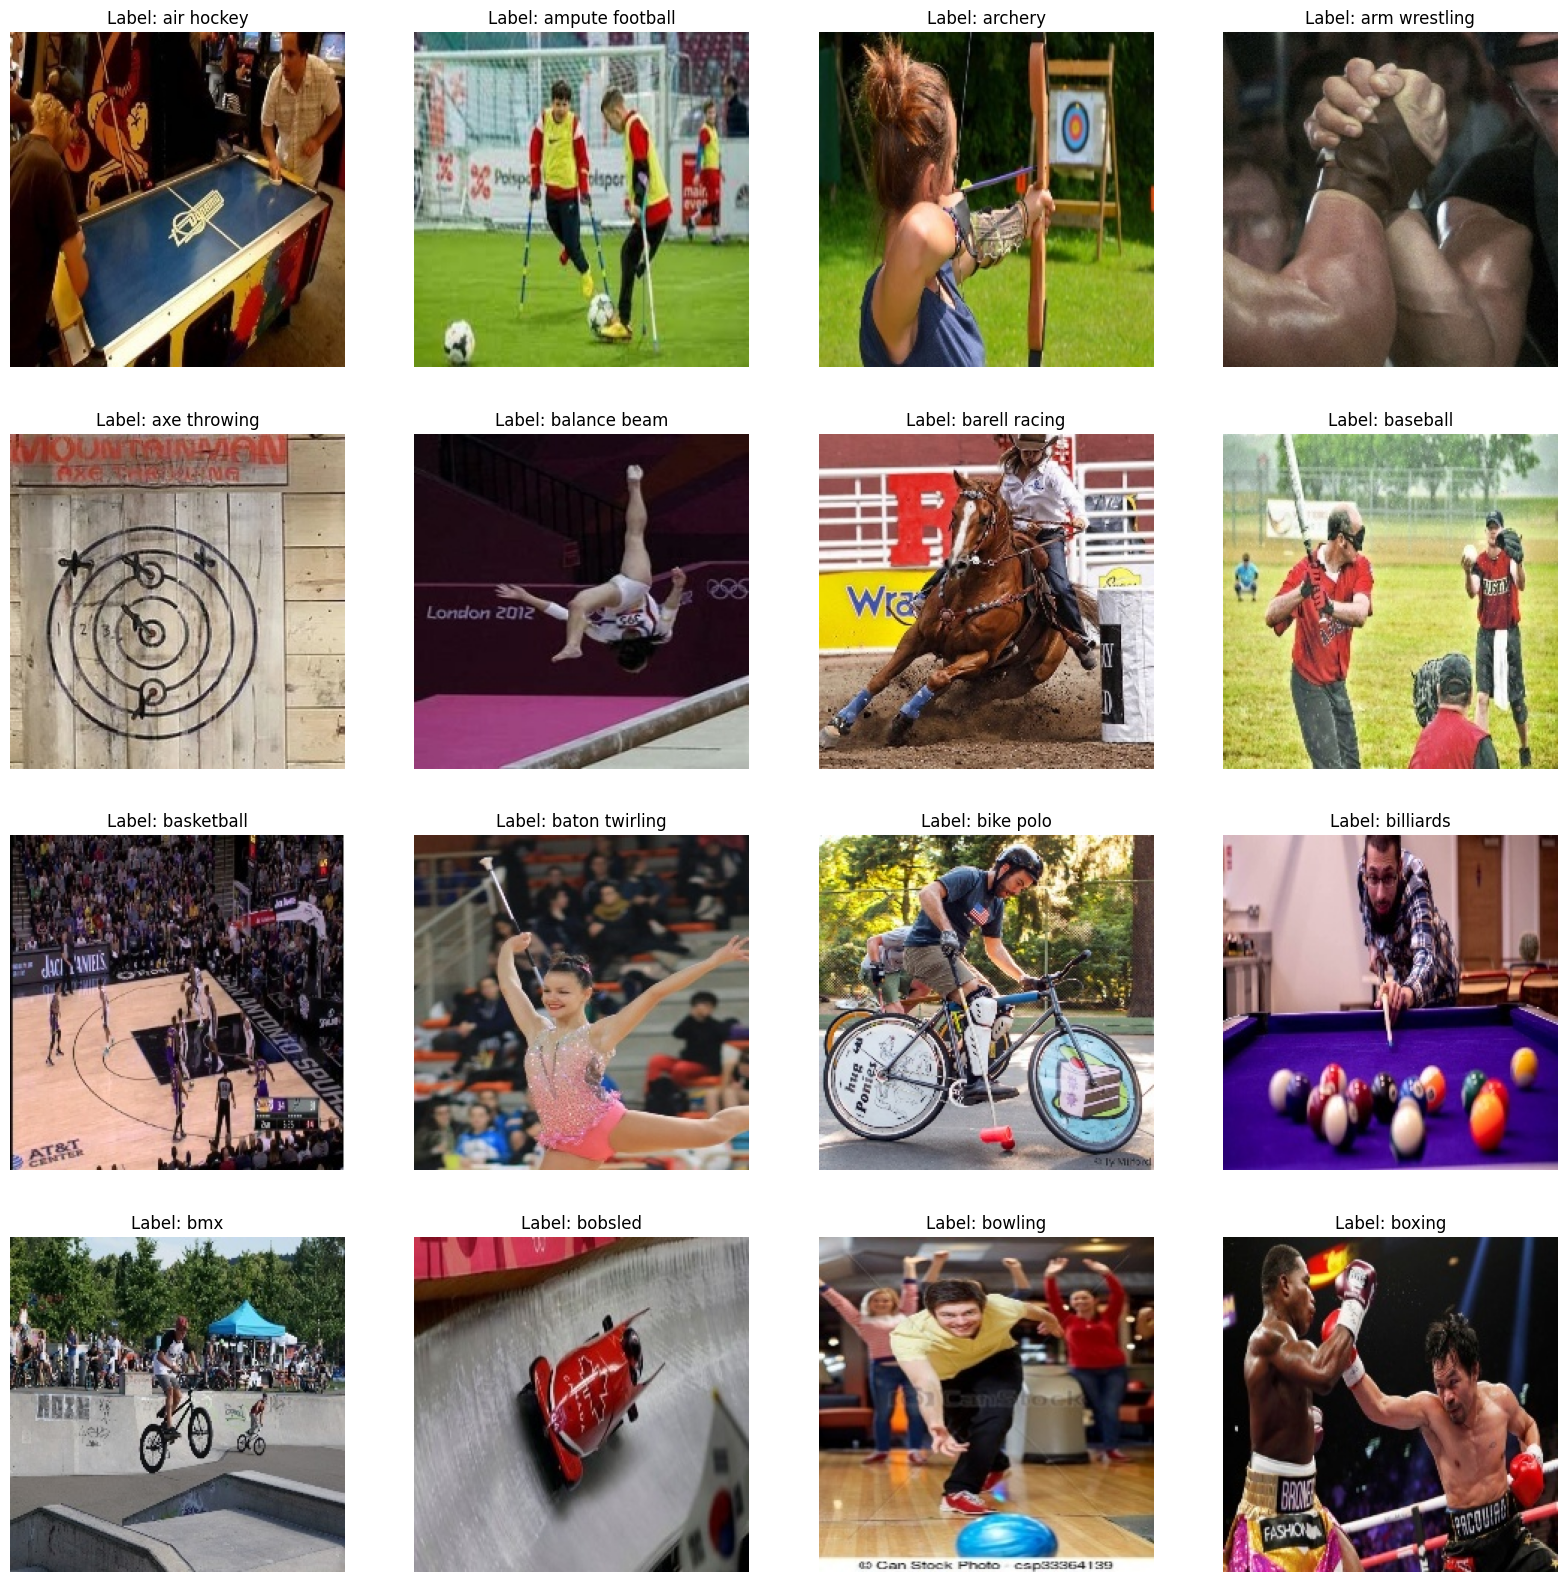

In [5]:
def get_random_image_with_label(root_dir, num_images=16):
    result_data = []

    # Iterate through each folder
    for folder_name in sports_list:
        folder_path = os.path.join(root_dir, folder_name)

        # Check if the path is a directory
        if os.path.isdir(folder_path):
            # Get a list of images in the folder
            images = [img for img in os.listdir(folder_path)]

            # Check if there are any images in the folder
            if images:
                # Select a random image from the folder
                random_image = random.choice(images)

                # Get the label (assuming the folder name is the label)
                label = folder_name

                # Add the image path and label to the result list
                result_data.append({'image_path': os.path.join(folder_path, random_image), 'label': label})

                # Break the loop if the desired number of images is reached
                if len(result_data) == num_images:
                    break

    return result_data

# Get 16 random images with labels, one from each folder
selected_data = get_random_image_with_label(TRAIN_DATA_PATH)

# Display the selected images with labels
plt.figure(figsize=(20,20))
for index, data in enumerate(selected_data):
    plt.subplot(4, 4, index+1)
    img = cv2.imread(data['image_path'])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.title(f"Label: {data['label']}")
    plt.axis('off')
plt.show()

In [6]:
## Getting the train, test and validation data

train_data = image_dataset_from_directory(
    directory=TRAIN_DATA_PATH,
    labels="inferred",
    label_mode="categorical",
    shuffle=True,
    class_names=sports_list,
    seed=39,
    image_size=(224, 224),
    batch_size=32
)

test_data = image_dataset_from_directory(
    directory=TEST_DATA_PATH,
    labels="inferred",
    label_mode="categorical",
    class_names=sports_list,
    seed=39,
    image_size=(224, 224),
    batch_size=32
)

validation_data = image_dataset_from_directory(
    directory=VALIDATION_DATA_PATH,
    labels="inferred",
    label_mode="categorical",
    class_names=sports_list,
    seed=39,
    image_size=(224, 224),
    batch_size=32
)

Found 13492 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [7]:
y_true_labels = []
testing_images = []
for image, label in test_data.unbatch().as_numpy_iterator():
    y_true_labels.append(np.argmax(label))
    testing_images.append(image.tolist())

In [13]:
## Efficient B0 model
efficientB0_model = efficientnet.EfficientNetB0(
    weights = "imagenet",
    input_shape = (224, 224, 3),
    include_top = False,
)

for layer in efficientB0_model.layers:
    layer.trainable = False

## ResNet50 model
resnet50_model = resnet.ResNet50(
    weights = "imagenet",
    input_shape = (224, 224, 3),
    include_top = False,
)

for layer in resnet50_model.layers:
    layer.trainable = False

## MobileNet_v1.2 model
mobilenetv2_model = mobilenet_v2.MobileNetV2(
    weights = "imagenet",
    input_shape = (224, 224, 3),
    include_top=False
)

for layer in mobilenetv2_model.layers:
    layer.trainable = False

inception_net_model = inception_v3.InceptionV3(
    input_shape = (224,224,3),
    weights="imagenet",
    include_top=False
)

for layer in inception_net_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 24s 0us/step


In [9]:
## Efficient B0 model
efficient_preprossed_date = efficientnet.preprocess_input(input_tensor)
efficient_X = efficientB0_model(efficient_preprossed_date)
efficient_X = GlobalAveragePooling2D()(efficient_X)
efficient_X = Dropout(0.2)(efficient_X)
efficient_X = Dense(512, activation="relu")(efficient_X)
efficient_X = Dropout(0.2)(efficient_X)
efficient_X = Dense(len(sports_list), activation="softmax")(efficient_X)
efficient_final_model = Model(inputs=input_tensor, outputs=efficient_X)

efficient_final_model.compile(
    optimizer = Adam(0.001), 
    loss="categorical_crossentropy", 
    metrics=[
        "accuracy"
    ]
)

efficient_final_model.summary()

## Efficient Net B0 model training
efficient_model_training_history = efficient_final_model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data,
    verbose=1
)

efficient_final_model.evaluate(test_data)

effient_y_preds = np.argmax(efficient_final_model.predict(np.array(testing_images)), axis=1)
print(accuracy_score(y_true_labels, effient_y_preds))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

In [10]:
## Resnet model
resnet_preprossed_data = resnet.preprocess_input(input_tensor)
resnet_X = resnet50_model(resnet_preprossed_data)
resnet_X = GlobalAveragePooling2D()(resnet_X)
resnet_X = Dropout(0.2)(resnet_X)
resnet_X = Dense(512, activation="relu")(resnet_X)
resnet_X = Dropout(0.2)(resnet_X)
resnet_X = Dense(len(sports_list), activation="softmax")(resnet_X)
resnet_final_model = Model(inputs=input_tensor, outputs=resnet_X)

resnet_final_model.compile(
    optimizer="adam", 
    loss="categorical_crossentropy", 
    metrics=[
        "accuracy"
    ]
)

resnet_final_model.summary()

## Resnet50 model training
resnet_model_training_history = resnet_final_model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data,
    verbose=1
)

resnet_final_model.evaluate(test_data)

resnet_y_preds = np.argmax(resnet_final_model.predict(np.array(testing_images)), axis=1)
print(accuracy_score(y_true_labels, resnet_y_preds))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0   

In [11]:
## MobileNet model
processor_input = mobilenet_v2.preprocess_input(input_tensor)
X = mobilenetv2_model(processor_input)
X = GlobalAveragePooling2D()(X)
X = Dropout(0.2)(X)
X = Dense(512, activation="relu")(X)
X = Dropout(0.2)(X)
X = Dense(100, activation="softmax")(X)
mobilenet_final_model = Model(inputs=input_tensor, outputs=X)

mobilenet_final_model.compile(
    optimizer="adam", 
    loss="categorical_crossentropy", 
    metrics=[
        "accuracy"
    ]
)

mobilenet_final_model.summary()

## Mobile NetV0 model training
mobile_model_training_history = mobilenet_final_model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data,
    verbose=1
)

mobilenet_final_model.evaluate(test_data)

mobilenet_y_preds = np.argmax(mobilenet_final_model.predict(np.array(testing_images)), axis=1)
print(accuracy_score(y_true_labels, mobilenet_y_preds))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [15]:
## Inception Net v3 model
inceptnet_processed_input = inception_v3.preprocess_input(input_tensor)
incept_X = inception_net_model(inceptnet_processed_input)
incept_X = GlobalAveragePooling2D()(incept_X)
incept_X = Dropout(0.2)(incept_X)
incept_X = Dense(512, activation="relu")(incept_X)
incept_X = Dropout(0.2)(incept_X)
incept_X = Dense(100, activation="softmax")(incept_X)
inceptionnet_final_model = Model(inputs=input_tensor, outputs=X)

inceptionnet_final_model.compile(
    optimizer="adam", 
    loss="categorical_crossentropy", 
    metrics=[
        "accuracy"
    ]
)

inceptionnet_final_model.summary()

## Mobile NetV0 model training
inception_net_model_training_history = inceptionnet_final_model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data,
    verbose=1
)

inceptionnet_final_model.evaluate(test_data)

inceptionnet_y_preds = np.argmax(inceptionnet_final_model.predict(np.array(testing_images)), axis=1)
print(accuracy_score(y_true_labels, inceptionnet_y_preds))


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [24]:
true_labels = 

In [52]:
y_true_labels

[65,
 6,
 92,
 39,
 70,
 95,
 87,
 23,
 77,
 4,
 25,
 52,
 84,
 16,
 60,
 78,
 2,
 62,
 8,
 31,
 86,
 42,
 72,
 32,
 5,
 1,
 74,
 7,
 88,
 20,
 4,
 92,
 98,
 26,
 64,
 60,
 6,
 22,
 42,
 28,
 72,
 44,
 54,
 31,
 0,
 10,
 48,
 27,
 63,
 23,
 78,
 50,
 52,
 98,
 73,
 89,
 92,
 35,
 51,
 47,
 57,
 50,
 38,
 36,
 36,
 21,
 42,
 54,
 72,
 68,
 56,
 44,
 99,
 75,
 7,
 60,
 31,
 43,
 67,
 51,
 47,
 69,
 79,
 95,
 29,
 30,
 16,
 19,
 91,
 81,
 81,
 39,
 0,
 74,
 85,
 57,
 37,
 53,
 5,
 10,
 77,
 43,
 12,
 13,
 53,
 12,
 83,
 30,
 84,
 66,
 96,
 11,
 68,
 28,
 79,
 32,
 10,
 35,
 49,
 23,
 18,
 89,
 83,
 58,
 94,
 26,
 59,
 46,
 96,
 27,
 61,
 50,
 20,
 73,
 94,
 36,
 3,
 31,
 41,
 94,
 85,
 24,
 93,
 35,
 63,
 83,
 86,
 4,
 90,
 58,
 40,
 70,
 69,
 98,
 27,
 37,
 19,
 4,
 81,
 78,
 9,
 49,
 41,
 90,
 29,
 90,
 18,
 53,
 32,
 37,
 66,
 59,
 31,
 84,
 3,
 71,
 37,
 16,
 1,
 84,
 29,
 27,
 73,
 21,
 4,
 1,
 22,
 87,
 25,
 61,
 62,
 21,
 49,
 76,
 54,
 79,
 14,
 10,
 2,
 20,
 20,
 46,
 55,
 12,
 3

In [40]:
test_data.file_paths

['D:/Manav/DataScience/Deep/CNN/common_data/test/figure skating pairs\\5.jpg',
 'D:/Manav/DataScience/Deep/CNN/common_data/test/water cycling\\2.jpg',
 'D:/Manav/DataScience/Deep/CNN/common_data/test/billiards\\5.jpg',
 'D:/Manav/DataScience/Deep/CNN/common_data/test/ice climbing\\2.jpg',
 'D:/Manav/DataScience/Deep/CNN/common_data/test/snow boarding\\5.jpg',
 'D:/Manav/DataScience/Deep/CNN/common_data/test/horse racing\\5.jpg',
 'D:/Manav/DataScience/Deep/CNN/common_data/test/wingsuit flying\\3.jpg',
 'D:/Manav/DataScience/Deep/CNN/common_data/test/sumo wrestling\\4.jpg',
 'D:/Manav/DataScience/Deep/CNN/common_data/test/horse jumping\\2.jpg',
 'D:/Manav/DataScience/Deep/CNN/common_data/test/rock climbing\\3.jpg',
 'D:/Manav/DataScience/Deep/CNN/common_data/test/sidecar racing\\5.jpg',
 'D:/Manav/DataScience/Deep/CNN/common_data/test/bike polo\\1.jpg',
 'D:/Manav/DataScience/Deep/CNN/common_data/test/motorcycle racing\\4.jpg',
 'D:/Manav/DataScience/Deep/CNN/common_data/test/chuckwagon

In [41]:
prediction_df = pd.DataFrame({
    "Actual_Test_Image_Name": [test_data.class_names[i] for i in y_true_labels],
    "Predicted_Image_Name": [test_data.class_names[i] for i in inceptionnet_y_preds],
    "Actual_Path": [test_data.file_paths[i] for i in y_true_labels]
})

In [50]:
prediction_df[prediction_df["Actual_Test_Image_Name"] != prediction_df["Predicted_Image_Name"]]

Actual_Test_Image_Name   Predicted_Image_Name  \
22         sailboat racing           ice yachting   
52                    judo                fencing   
56             uneven bars                trapeze   
70       motorcycle racing         sidecar racing   
88                ultimate                  rugby   
99               bike polo  wheelchair basketball   
103                bobsled                   luge   
105                    bmx           ice climbing   
113   figure skating pairs         baton twirling   
149          nascar racing         sidecar racing   
197              bike polo      wheelchair racing   
207               ultimate                  rugby   
232      snowmobile racing         sidecar racing   
233                bowling         baton twirling   
238                fencing               lacrosse   
245        steer wrestling            bull riding   
260          snow boarding           giant slalom   
263             pole vault             volleyball   
266         sumo wrestling             tug of war   
271               ultimate               lacrosse   
277                 tennis               baseball   
303             pole vault                javelin   
304                frisbee            log rolling   
314               ultimate                cricket   
322               baseball               football   
326                bobsled                   luge   
332             air hockey           table tennis   
338                bobsled                   luge   
339               baseball               football   
354      hydroplane racing                   luge   
357         bungee jumping                trapeze   
409      hydroplane racing           canoe slamon   
416                 tennis           table tennis   
452         baton twirling                archery   
455         sidecar racing      motorcycle racing   
479                   gaga           table tennis   
487        steer wrestling            bull riding   

                                           Actual_Path  
22   D:/Manav/DataScience/Deep/CNN/common_data/test...  
52   D:/Manav/DataScience/Deep/CNN/common_data/test...  
56   D:/Manav/DataScience/Deep/CNN/common_data/test...  
70   D:/Manav/DataScience/Deep/CNN/common_data/test...  
88   D:/Manav/DataScience/Deep/CNN/common_data/test...  
99   D:/Manav/DataScience/Deep/CNN/common_data/test...  
103  D:/Manav/DataScience/Deep/CNN/common_data/test...  
105  D:/Manav/DataScience/Deep/CNN/common_data/test...  
113  D:/Manav/DataScience/Deep/CNN/common_data/test...  
149  D:/Manav/DataScience/Deep/CNN/common_data/test...  
197  D:/Manav/DataScience/Deep/CNN/common_data/test...  
207  D:/Manav/DataScience/Deep/CNN/common_data/test...  
232  D:/Manav/DataScience/Deep/CNN/common_data/test...  
233  D:/Manav/DataScience/Deep/CNN/common_data/test...  
238  D:/Manav/DataScience/Deep/CNN/common_data/test...  
245  D:/Manav/DataScience/Deep/CNN/common_data/test...  
260  D:/Manav/DataScience/Deep/CNN/common_data/test...  
263  D:/Manav/DataScience/Deep/CNN/common_data/test...  
266  D:/Manav/DataScience/Deep/CNN/common_data/test...  
271  D:/Manav/DataScience/Deep/CNN/common_data/test...  
277  D:/Manav/DataScience/Deep/CNN/common_data/test...  
303  D:/Manav/DataScience/Deep/CNN/common_data/test...  
304  D:/Manav/DataScience/Deep/CNN/common_data/test...  
314  D:/Manav/DataScience/Deep/CNN/common_data/test...  
322  D:/Manav/DataScience/Deep/CNN/common_data/test...  
326  D:/Manav/DataScience/Deep/CNN/common_data/test...  
332  D:/Manav/DataScience/Deep/CNN/common_data/test...  
338  D:/Manav/DataScience/Deep/CNN/common_data/test...  
339  D:/Manav/DataScience/Deep/CNN/common_data/test...  
354  D:/Manav/DataScience/Deep/CNN/common_data/test...  
357  D:/Manav/DataScience/Deep/CNN/common_data/test...  
409  D:/Manav/DataScience/Deep/CNN/common_data/test...  
416  D:/Manav/DataScience/Deep/CNN/common_data/test...  
452  D:/Manav/DataScience/Deep/CNN/common_data/test

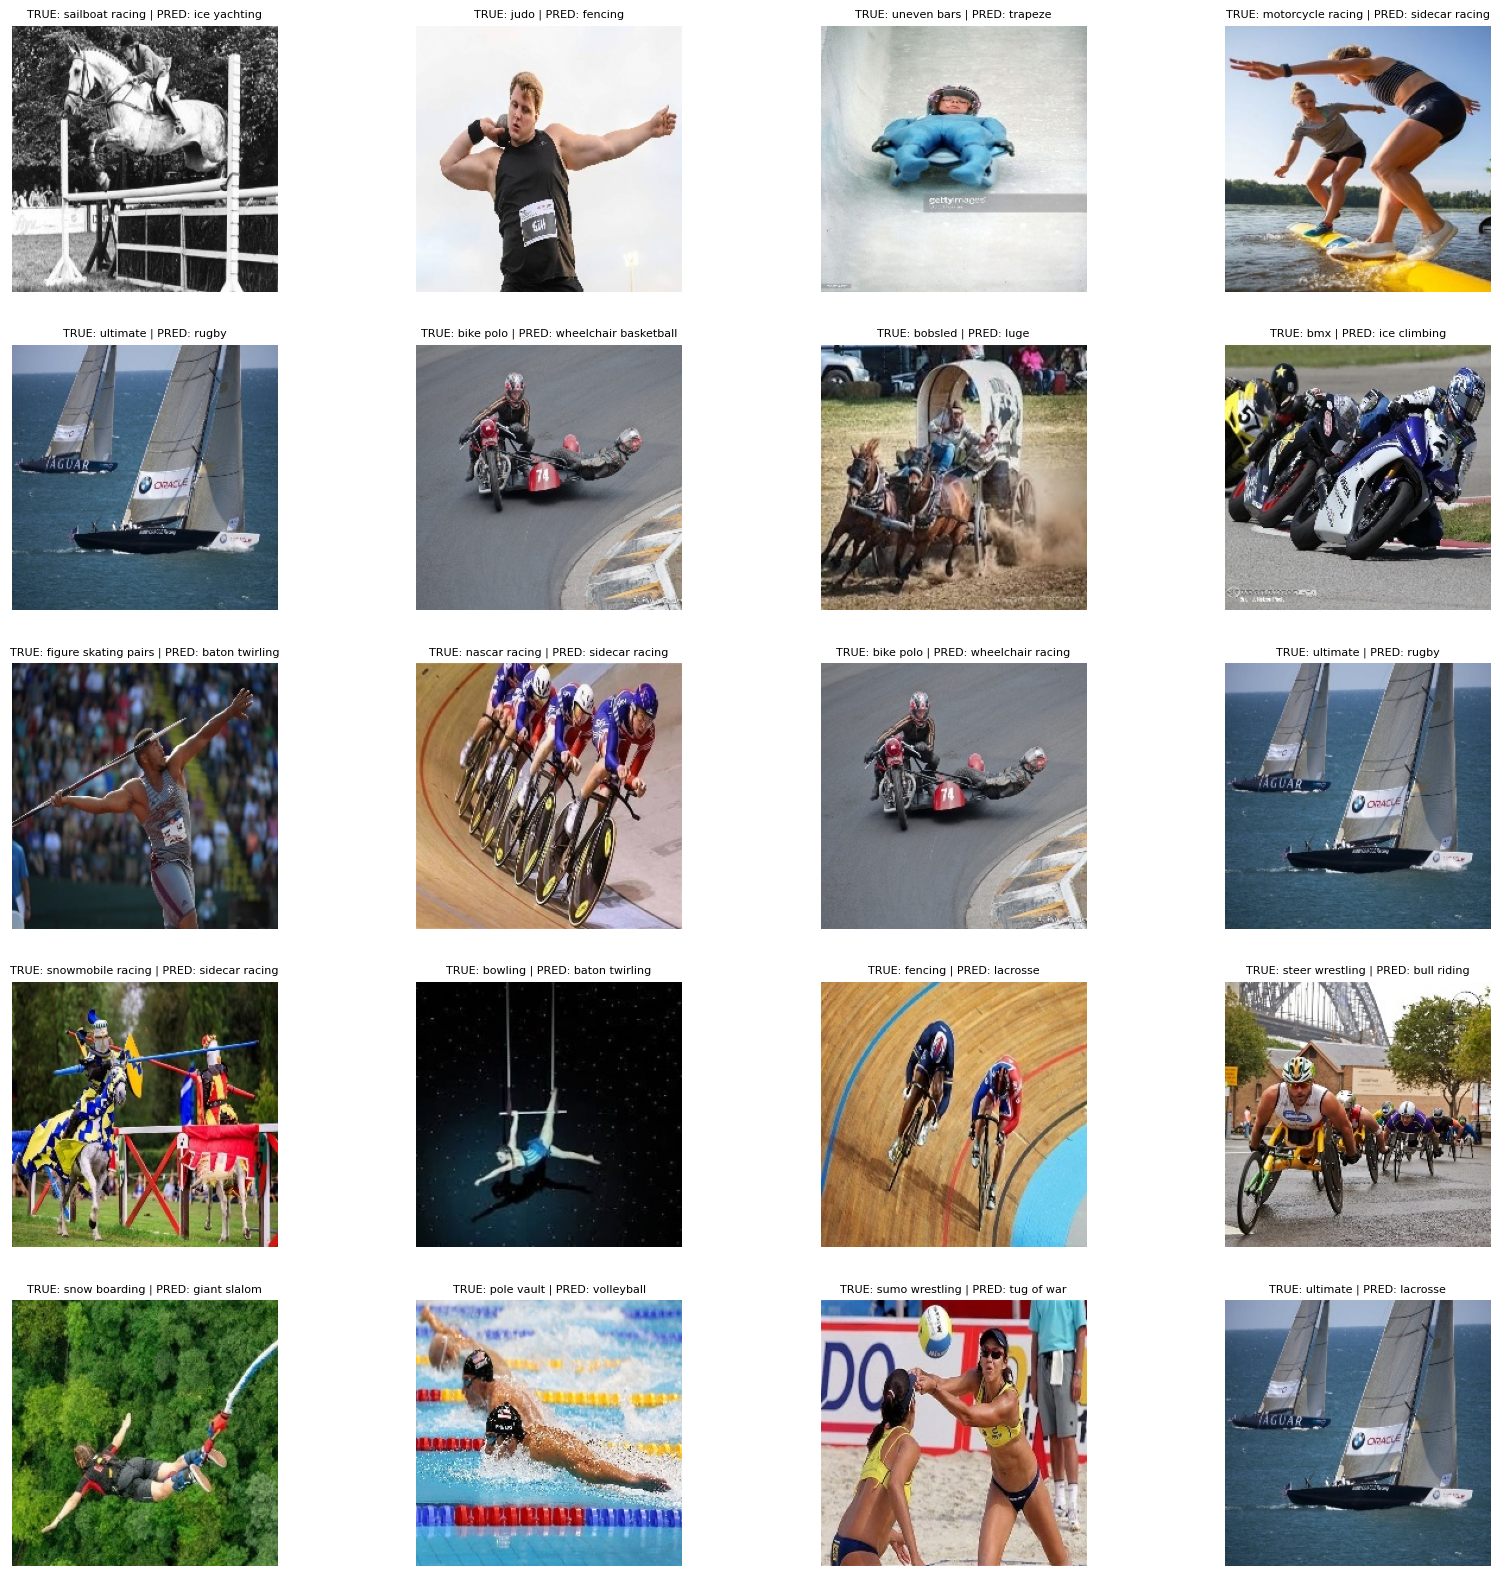

In [51]:
plt.figure(figsize=(20,20))
for index, row in prediction_df[prediction_df["Actual_Test_Image_Name"] != prediction_df["Predicted_Image_Name"]].head(20).reset_index().iterrows():
    plt.subplot(5,4,index+1)

    img = cv2.imread(row["Actual_Path"])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.title(f'TRUE: {row["Actual_Test_Image_Name"]} | PRED: {row["Predicted_Image_Name"]}', fontsize=8)
    plt.axis('off')
plt.show()